In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Read SiPM pulse shape from csv

In [2]:
import csv
pulse_pars_top = []
pulse_pars_bot = []
with open('pulse_parameters_65V.csv') as f:
    r = csv.reader(f)
    line_count = 0
    for row in r:
        if line_count>0:
            if line_count<=4:
                pulse_pars_top.append([float(par) for par in row[1:]])
                print(pulse_pars_top[-1])
            else:
                pulse_pars_bot.append([float(par) for par in row[1:]])
                print(pulse_pars_bot[-1])
        line_count += 1


[4.785269765091801, 0.24465717230046793, 4.073501733077282, 0.019567625094531624]
[1.6673254424459918, 0.47719420237660765, 4.903429623168718, 0.08571027976327786]
[1.7772347297673032, 0.420307822140636, 5.259472382086961, 0.06012379531673089]
[5.46460121203827, 0.27214909992926917, 4.358305910658269, 0.011102848302532735]
[3.159016495606167, 0.3970144047422518, 4.072443314855156, 0.04496687268229123]
[0.9718248355955384, 0.8285785218030871, 5.524493722728364, 0.1028647225158728]
[1.382881398253107, 0.7346785481410949, 5.30060245748518, 0.07496312866265117]
[0.7145097171380426, 0.8118939509327021, 5.570884898422146, 0.0740521372552768]


# List of Datasets
- Bottom:
    * 11/07: 1-6, overnight
    * 11/09: high stat
    * 11/10: high stat, overnight
- Top:
    * 11/08: 0, overnight
    * 11/09: high stat
    * 11/10: high stat

# Bottom 11/07 11/09 11/10 Day

In [27]:
# subdir: 0-9
dir1107bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/'
#subdir: 0-19
dir1109bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/'

In [28]:
ds_bot = []
nsubdir = [10,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1107bot, dir1109bot, dir1110bot]):
    for j in range(nsubdir[i]):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[1])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_bot.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_1/5/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/20

## Deconvolution channel by channel

ch0 A_S=1.80+/-0.02  TAU_S=0.0289+/-0.0005us  A_T=0.19+/-0.00  TAU_T=0.637+/-0.014us sigma=0.0084+/-0.0002us t0=6.258+/-0.000us
ch1 A_S=2.88+/-0.05  TAU_S=0.0211+/-0.0005us  A_T=0.25+/-0.00  TAU_T=0.614+/-0.012us sigma=0.0095+/-0.0002us t0=6.258+/-0.000us
ch2 A_S=2.62+/-0.03  TAU_S=0.0215+/-0.0003us  A_T=0.25+/-0.00  TAU_T=0.618+/-0.008us sigma=0.0089+/-0.0001us t0=6.257+/-0.000us
ch3 A_S=1.97+/-0.03  TAU_S=0.0246+/-0.0005us  A_T=0.19+/-0.00  TAU_T=0.795+/-0.016us sigma=0.0083+/-0.0002us t0=6.258+/-0.000us
ch0 A_S=1.66+/-0.02  TAU_S=0.0305+/-0.0005us  A_T=0.18+/-0.00  TAU_T=1.159+/-0.018us sigma=0.0083+/-0.0002us t0=6.257+/-0.000us
ch1 A_S=2.30+/-0.04  TAU_S=0.0192+/-0.0004us  A_T=0.12+/-0.00  TAU_T=1.731+/-0.034us sigma=0.0087+/-0.0002us t0=6.259+/-0.000us
ch2 A_S=2.03+/-0.02  TAU_S=0.0236+/-0.0003us  A_T=0.18+/-0.00  TAU_T=1.255+/-0.014us sigma=0.0089+/-0.0001us t0=6.255+/-0.000us
ch3 A_S=1.68+/-0.02  TAU_S=0.0342+/-0.0006us  A_T=0.24+/-0.00  TAU_T=1.296+/-0.018us sigma=0.0085+/-0.00

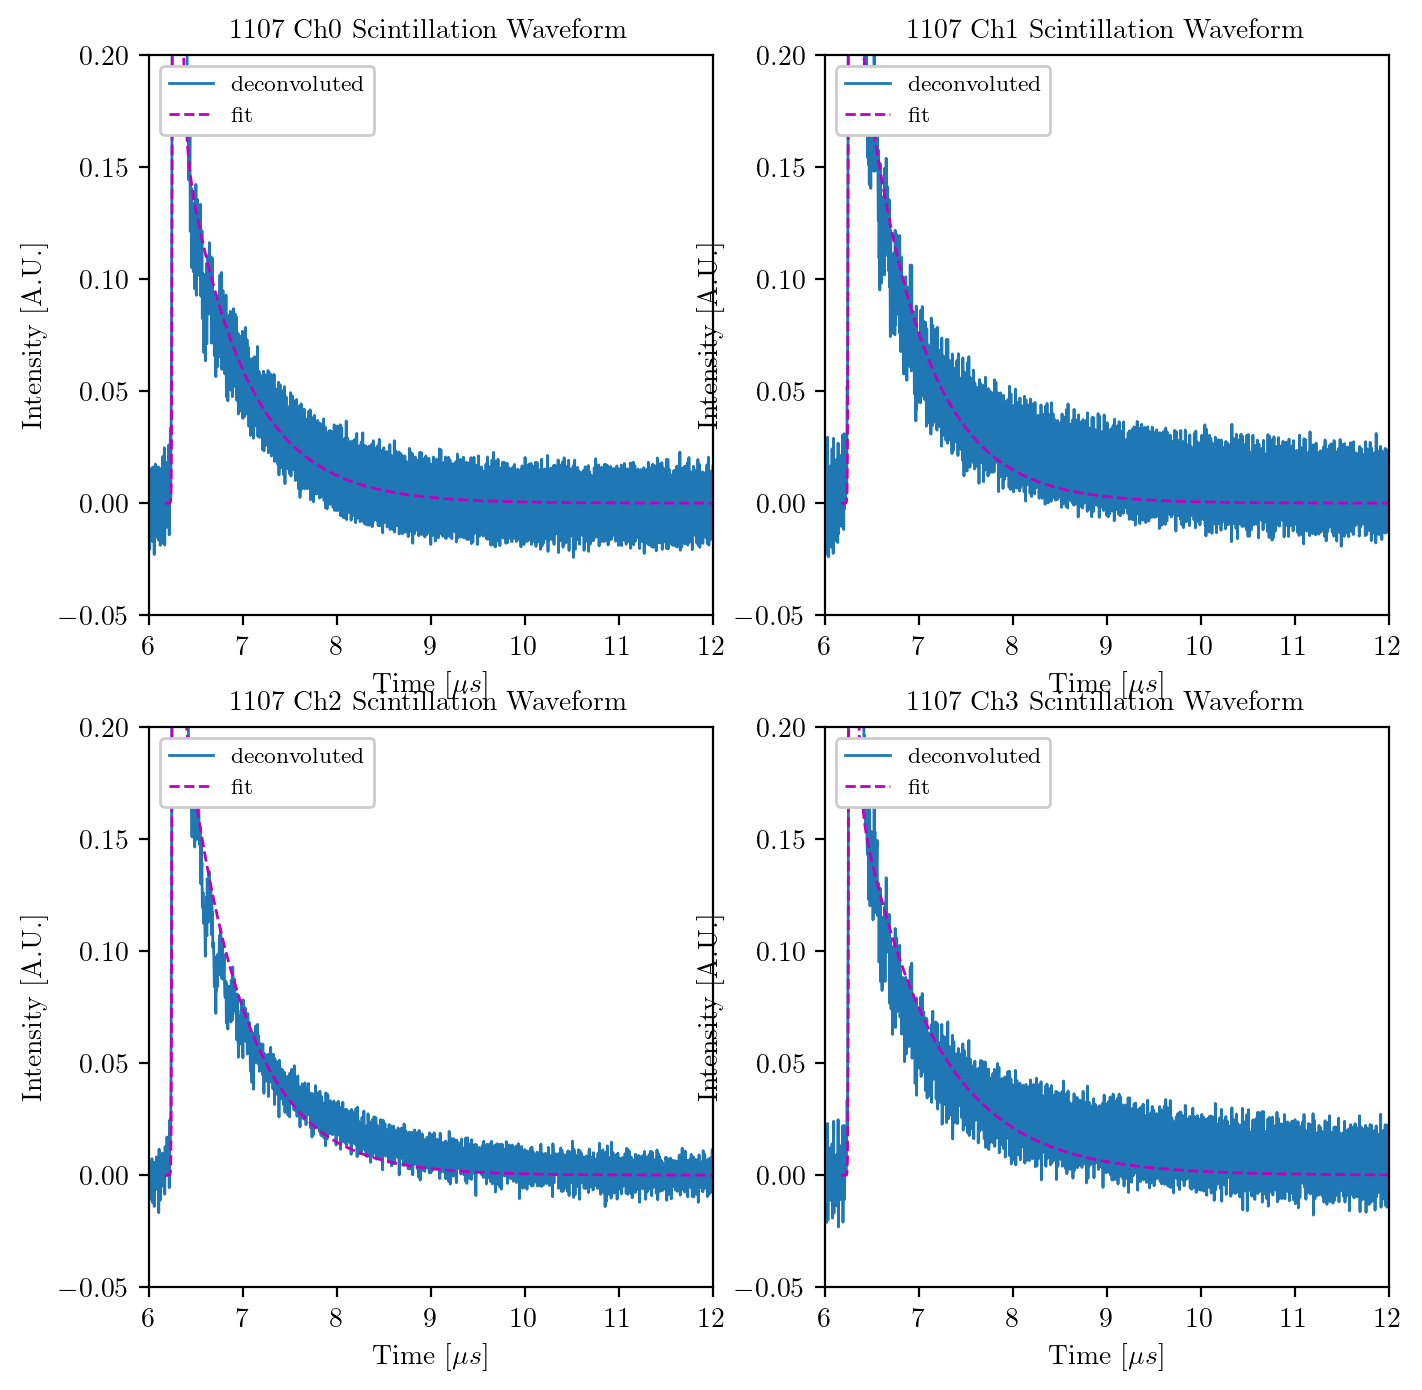

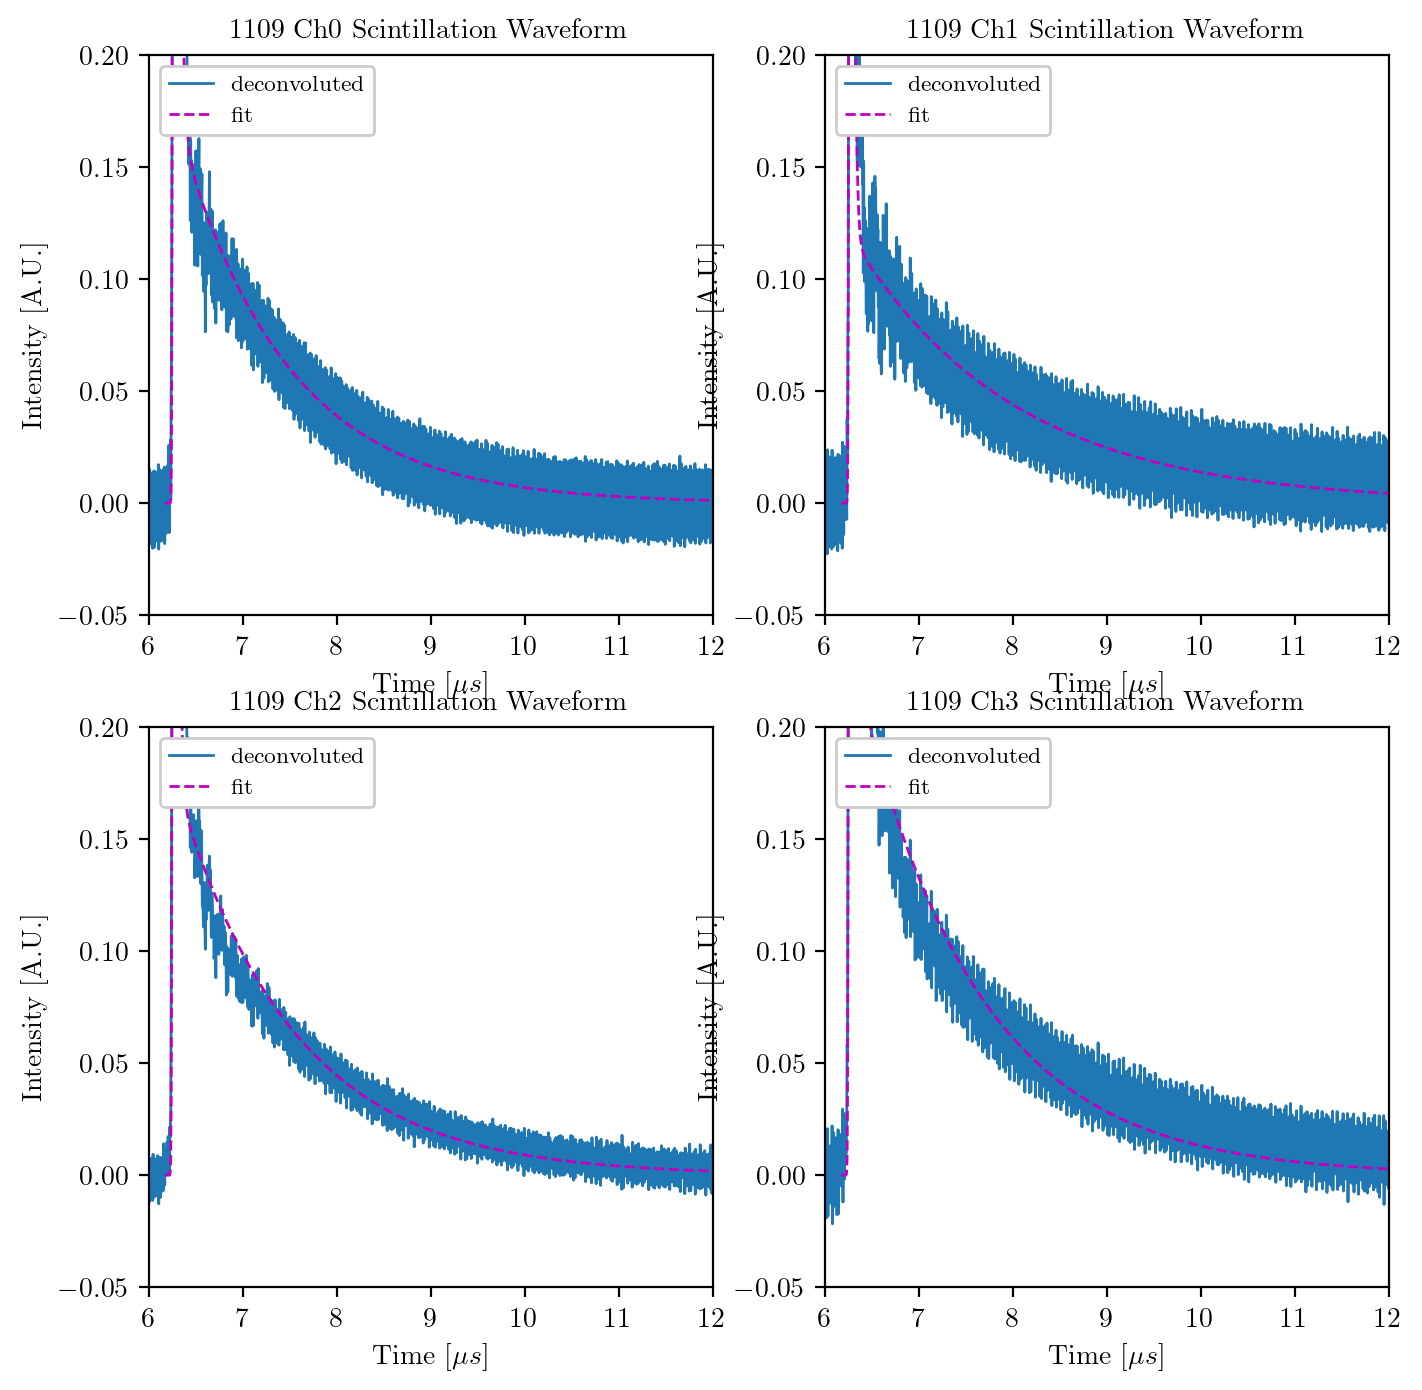

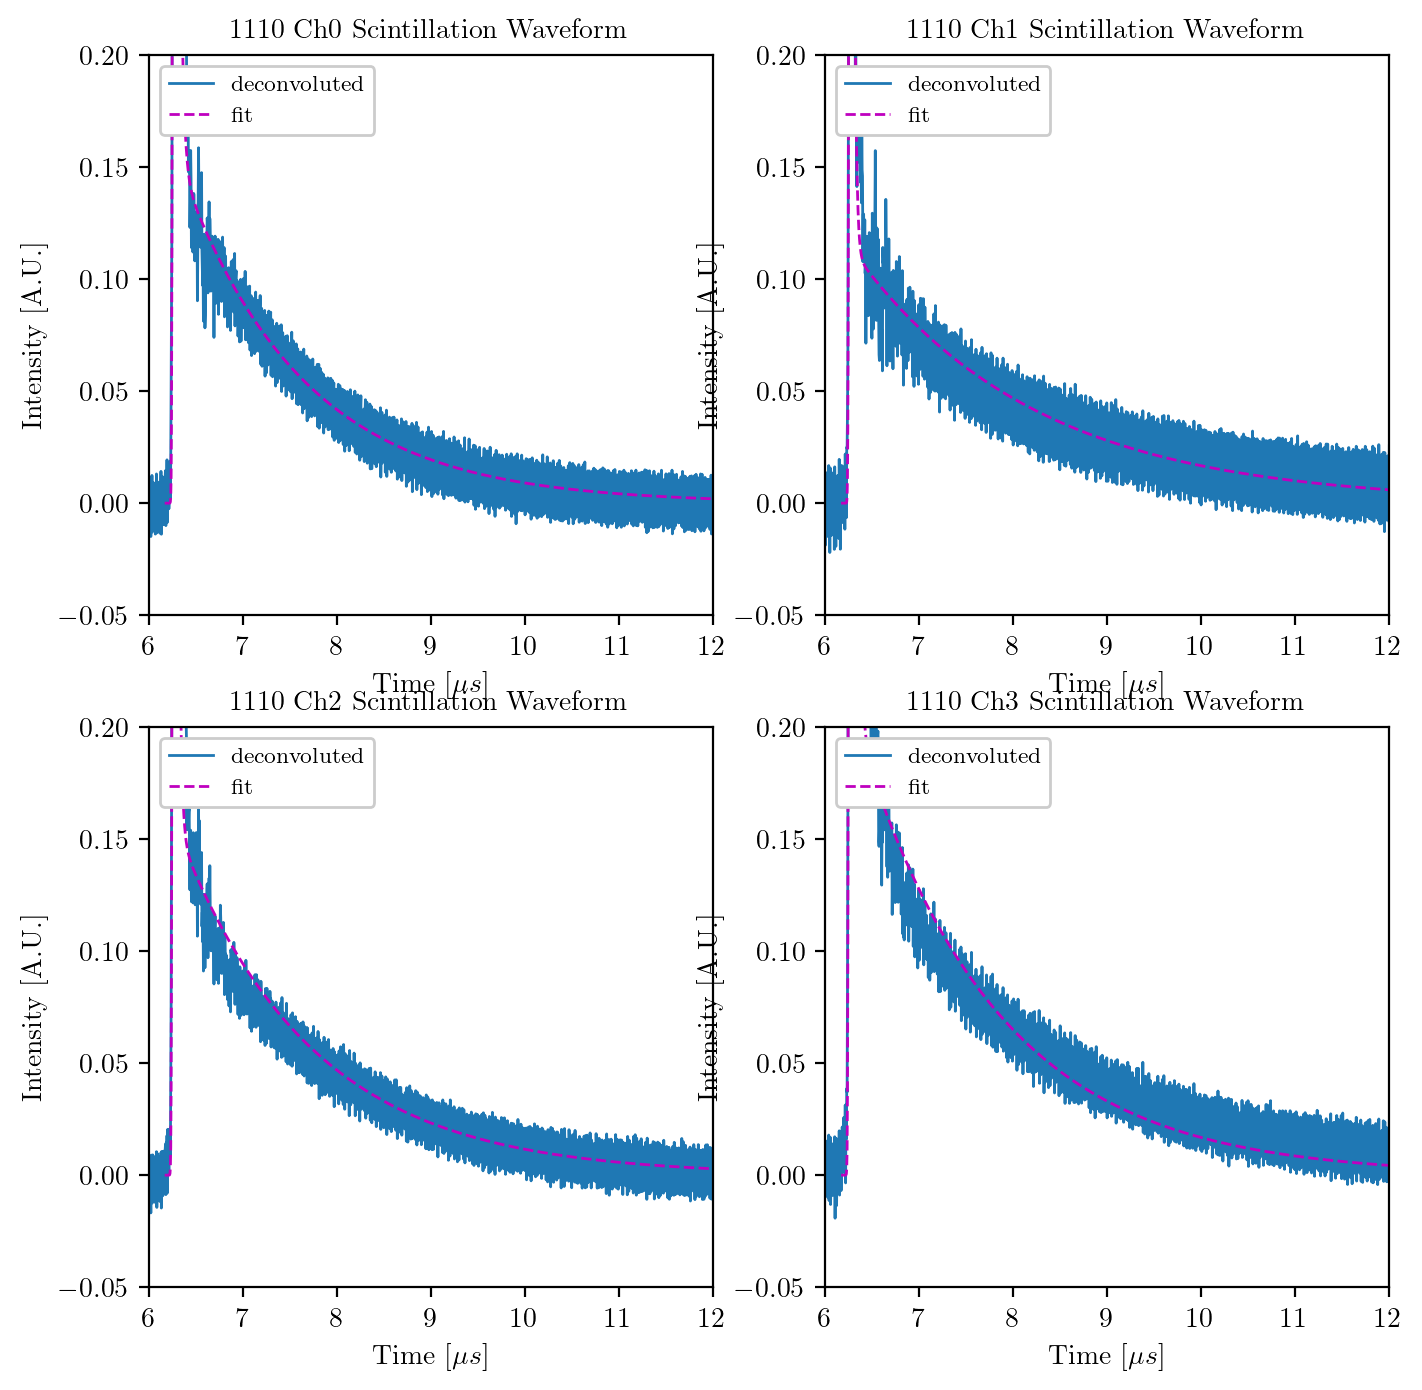

In [29]:
from scipy.fft import fft, ifft
f_deconv_sum_bot = []
date = ['1107','1109','1110']
for i,dset in enumerate(ds_bot):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_day = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(*pulse_pars_bot[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_day += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum_bot.append(f_deconv_sum_day)

## Summed scintillation pulse

11/07 A_S=4.7726+/-1663265.5822  TAU_S=0.1056+/-0.0021us  A_T=0.5672+/-20366.6483  TAU_T=1.0613+/-0.0131us sigma=0.0285+/-6029.4956us t0=6.1462+/-38250.3330us
11/09 A_S=3.7914+/-6.1268  TAU_S=0.0849+/-0.0046us  A_T=0.6334+/-0.0756  TAU_T=1.5437+/-0.0110us sigma=0.0695+/-0.0691us t0=6.1594+/-0.1841us
11/10 A_S=2.7256+/-2.2608  TAU_S=0.0793+/-0.0048us  A_T=0.5789+/-0.0302  TAU_T=1.7092+/-0.0115us sigma=0.0644+/-0.0385us t0=6.1909+/-0.0874us


/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:317: RuntimeWarning: invalid value encountered in add
  return pulse_jitter(t, a_s, tau_s, sigma, t0) + pulse_jitter(t, a_t, tau_t, sigma, t0)


Text(0.5, 0.98, 'Bottom Chamber')

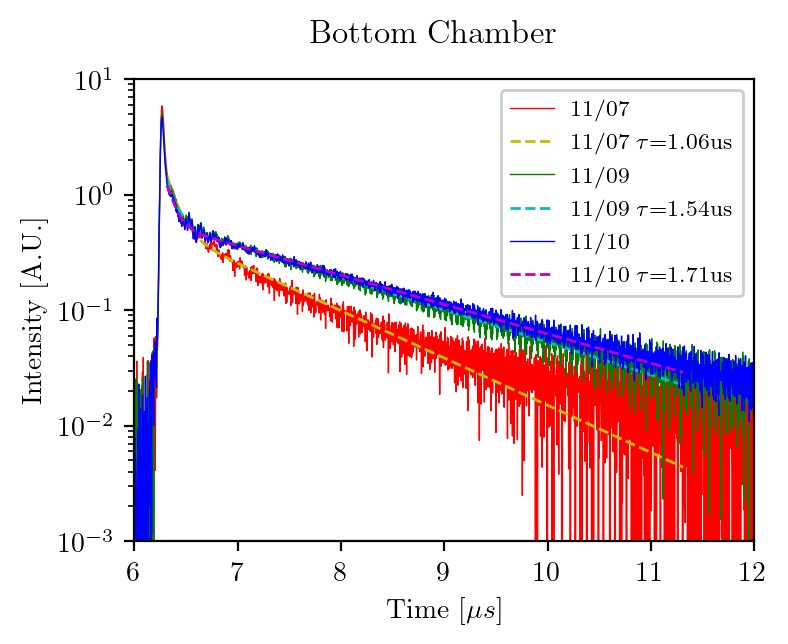

In [30]:
colors = ['r', 'g', 'b']
colors_fit = ['y','c','m']
labels = ['11/07', '11/09', '11/10']
tau_triplet_bot = []
for i,fdc in enumerate(f_deconv_sum_bot):
    dset = ds_bot[i].ch[0]
    t0 = np.argmax(fdc)+int(0.05/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_bot.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(dset.time, fdc, '{}-'.format(colors[i]), label=labels[i], linewidth=0.5)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '{}--'.format(colors_fit[i]), label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 12)
plt.ylim(1e-3, 1e1)
plt.suptitle('Bottom Chamber')

## Triplet lifetime evolution

(0.8, 2.0)

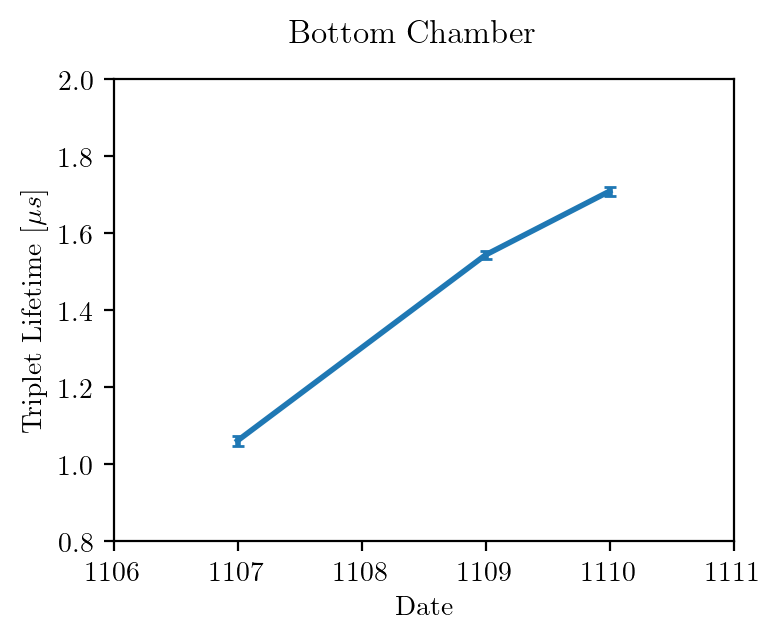

In [31]:
date_bot = [1107, 1109, 1110]
tau_triplet_bot = np.array(tau_triplet_bot)
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.suptitle('Bottom Chamber')
plt.ylim(0.8, 2.0)

# Top 11/08 11/09 11/10 Day

In [32]:
# subdir: 0
dir1108top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/'
#subdir: 0-19
dir1109top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
#subdir: 0-19
dir1110top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'

In [33]:
ds_top = []
nsubdir = [1,20,20]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1108top, dir1109top, dir1110top]):
    for j in range(nsubdir[i]):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[0])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds_top.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_0/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-09/2022-11-09_volt_65_pos_top_light_scintillation_coinc_111_c

## Deconvolution channel by channel

ch0 A_S=0.67+/-0.02  TAU_S=0.0258+/-0.0009us  A_T=0.08+/-0.00  TAU_T=1.017+/-0.024us sigma=0.0110+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.62+/-0.30  TAU_S=0.0095+/-0.0017us  A_T=0.18+/-0.00  TAU_T=0.559+/-0.013us sigma=0.0131+/-0.0006us t0=6.250+/-0.001us
ch2 A_S=0.73+/-0.02  TAU_S=0.0268+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.134+/-0.019us sigma=0.0105+/-0.0003us t0=6.246+/-0.000us
ch3 A_S=1.12+/-0.06  TAU_S=0.0145+/-0.0008us  A_T=0.04+/-0.00  TAU_T=1.598+/-0.043us sigma=0.0135+/-0.0003us t0=6.252+/-0.000us
ch0 A_S=0.68+/-0.02  TAU_S=0.0252+/-0.0010us  A_T=0.07+/-0.00  TAU_T=1.184+/-0.027us sigma=0.0107+/-0.0003us t0=6.248+/-0.000us
ch1 A_S=1.33+/-0.15  TAU_S=0.0120+/-0.0014us  A_T=0.17+/-0.00  TAU_T=0.668+/-0.014us sigma=0.0123+/-0.0005us t0=6.249+/-0.001us
ch2 A_S=0.74+/-0.02  TAU_S=0.0263+/-0.0007us  A_T=0.09+/-0.00  TAU_T=1.345+/-0.020us sigma=0.0104+/-0.0002us t0=6.247+/-0.000us
ch3 A_S=1.11+/-0.05  TAU_S=0.0144+/-0.0007us  A_T=0.04+/-0.00  TAU_T=1.819+/-0.041us sigma=0.0133+/-0.00

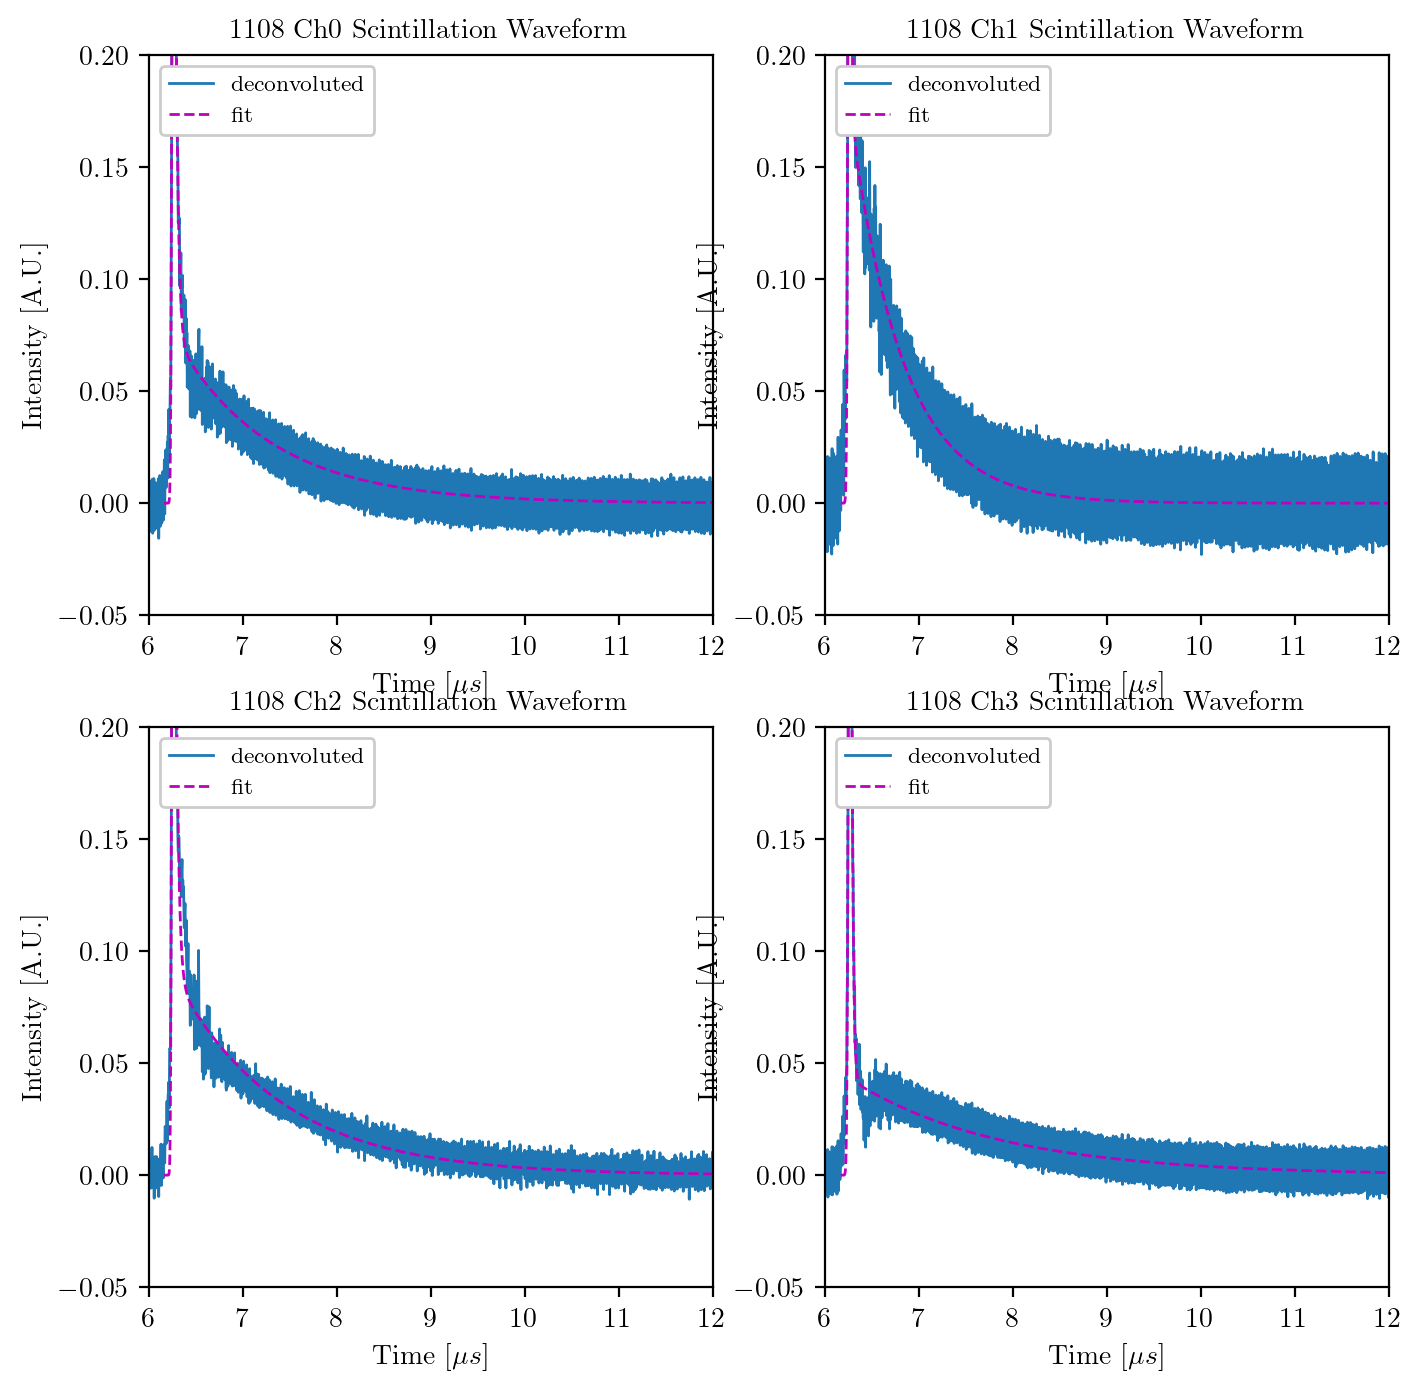

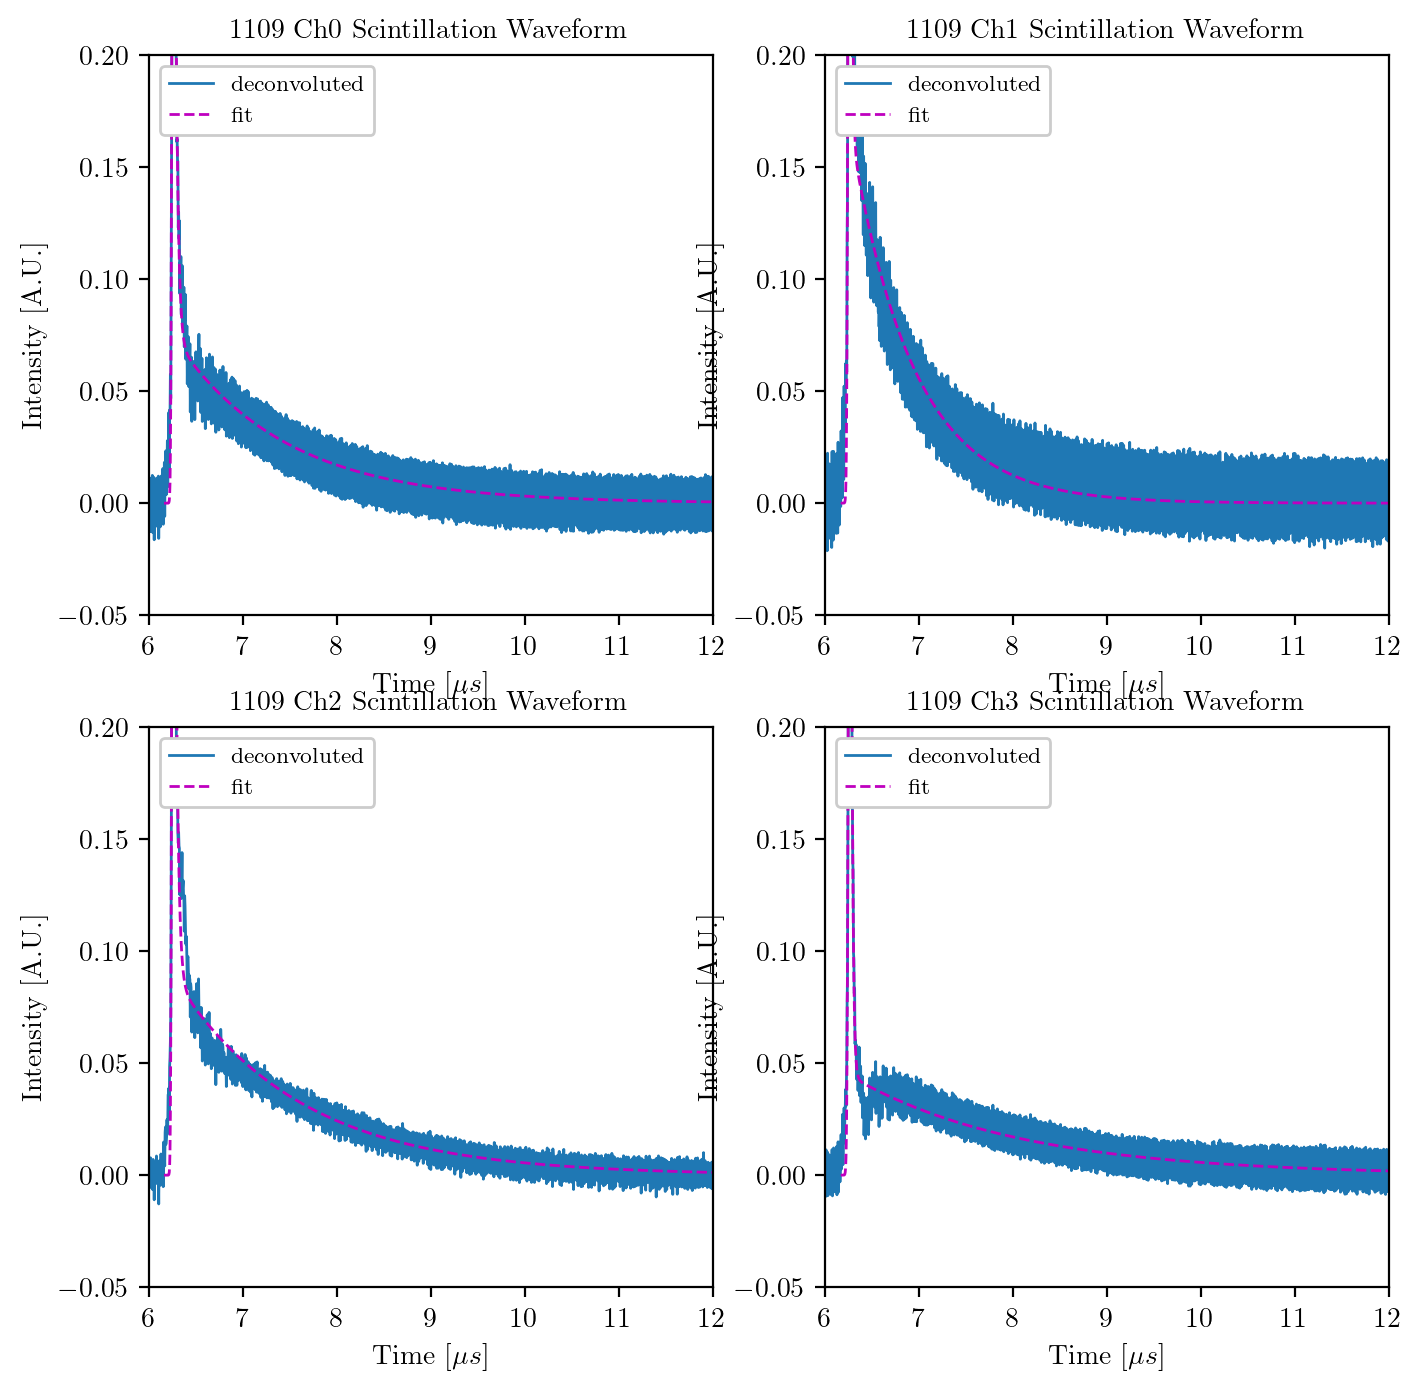

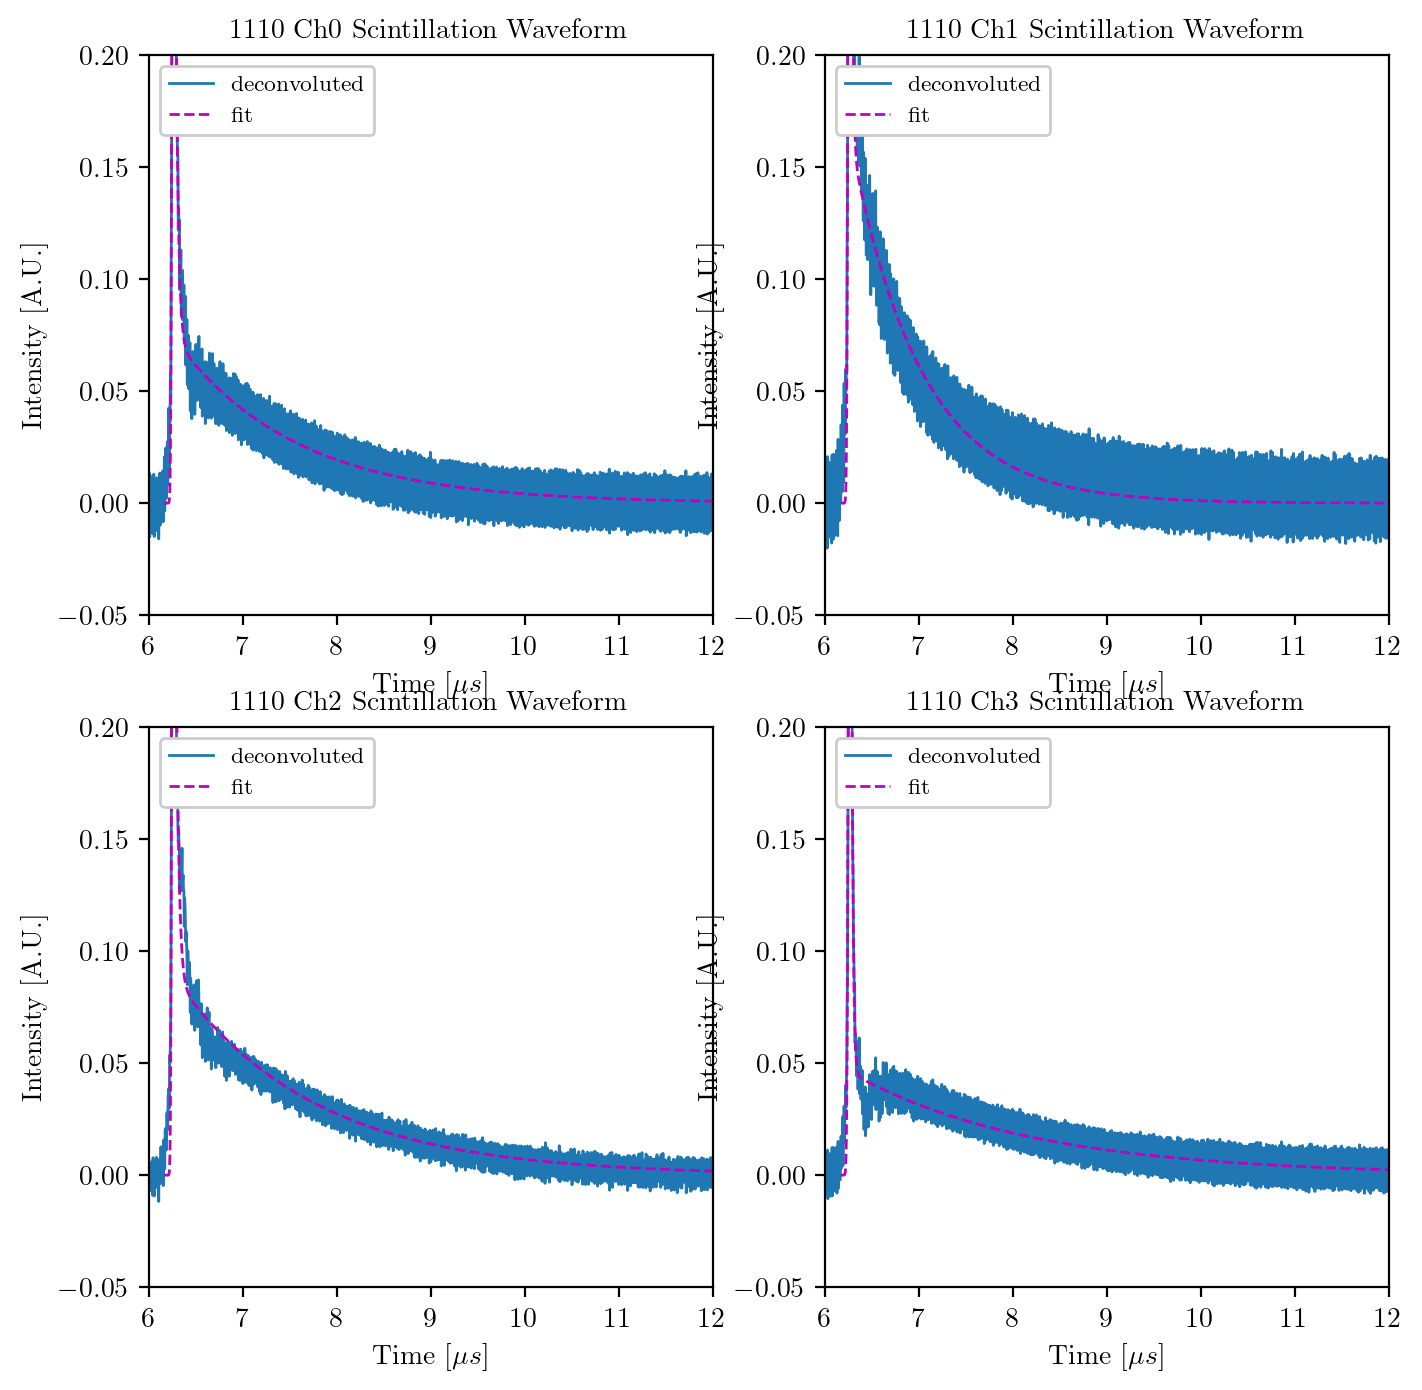

In [34]:
from scipy.fft import fft, ifft
f_deconv_sum_top = []
date = ['1108','1109','1110']
for i,dset in enumerate(ds_top):
    plt.figure(i,figsize=(8,8))
    f_deconv_sum_day = np.zeros(dset.ch[0].samples)
    for ch in range(4):
        dset.ch[ch].set_pulse_pars(*pulse_pars_top[ch])
        ftilde = fft(dset.ch[ch].avgwf)
        a1,tau1,a2,tau2 = dset.ch[ch].get_pulse_pars()
        h = lambda x: a1*np.exp(-x/tau1)+a2*np.exp(-x/tau2)
        htilde = fft(h(dset.ch[ch].time))
        f_deconv = ifft(ftilde/htilde).real
        f_deconv_sum_day += f_deconv
        t0 = np.argmax(f_deconv)-int(0.1/dset.ch[ch].sample_step)
        length = int(6/dset.ch[ch].sample_step)
        err = np.std(dset.ch[ch].avgwf[:dset.ch[ch].baseline_samples])
        popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], f_deconv[t0:t0+length], p0=[1, 0.02, 0.1, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
        print('ch{} A_S={:.2f}+/-{:.2f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.2f}+/-{:.2f}  TAU_T={:.3f}+/-{:.3f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.subplot(2,2,ch+1)
        plt.plot(dset.ch[ch].time, f_deconv, label='deconvoluted', linewidth=1)
        plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1)
        plt.title('{} Ch{} Scintillation Waveform'.format(date[i],ch))
        plt.ylabel('Intensity [A.U.]')
        plt.xlabel(r'Time [$\mu s$]')
        plt.legend()
        # plt.yscale('log')
        # plt.ylim(1e-3, 1e1)
        plt.ylim(-0.05,0.2)
        plt.xlim(6,12)
    f_deconv_sum_top.append(f_deconv_sum_day)

## Summed scintillation pulse

11/08 A_S=1.0043+/-899326.6717  TAU_S=0.0718+/-0.0040us  A_T=0.3231+/-19324.2780  TAU_T=1.0754+/-0.0130us sigma=0.0014+/-1106.2596us t0=6.2104+/-64309.4207us
11/09 A_S=0.8569+/-417444.8501  TAU_S=0.0746+/-0.0025us  A_T=0.3164+/-9057.9925  TAU_T=1.2691+/-0.0093us sigma=0.0048+/-2258.3995us t0=6.2191+/-36331.2317us
11/10 A_S=0.8778+/-378628.3585  TAU_S=0.0750+/-0.0023us  A_T=0.3194+/-7452.4910  TAU_T=1.3867+/-0.0090us sigma=0.0011+/-400.5032us t0=6.2178+/-32350.1974us


Text(0.5, 0.98, 'Top Chamber')

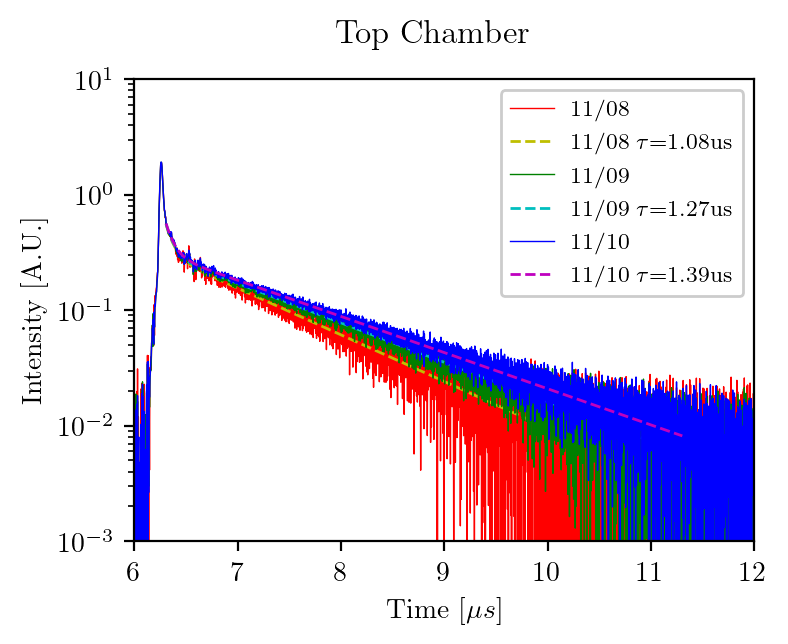

In [35]:
colors = ['r', 'g', 'b']
colors_fit = ['y','c','m']
labels = ['11/08', '11/09', '11/10']
tau_triplet_top = []
for i,fdc in enumerate(f_deconv_sum_top):
    dset = ds_top[i].ch[0]
    t0 = np.argmax(fdc)+int(0.05/dset.sample_step)
    length = int(5/dset.sample_step)
    err = np.std(fdc[:dset.baseline_samples])
    popt,pcov = curve_fit(dset.get_scintillation, dset.time[t0:t0+length], fdc[t0:t0+length], p0=[5, 0.02, 0.5, 1.2, 0.01, 6.25], sigma=[err]*length, maxfev=100000)
    print('{} A_S={:.4f}+/-{:.4f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.4f}+/-{:.4f}  TAU_T={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.4f}+/-{:.4f}us'.format(labels[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
    tau_triplet_top.append([popt[3], np.sqrt(pcov[3,3])])
    plt.plot(dset.time, fdc, '{}-'.format(colors[i]), label=labels[i], linewidth=0.5)
    plt.plot(dset.time[t0:t0+length], dset.get_scintillation(dset.time[t0:t0+length], *popt), '{}--'.format(colors_fit[i]), label=r'{} $\tau$={:.2f}us'.format(labels[i], popt[3]), linewidth=1)
    
plt.legend(loc='upper right')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Intensity [A.U.]')
plt.yscale('log')
plt.xlim(6, 12)
plt.ylim(1e-3, 1e1)
plt.suptitle('Top Chamber')

## Triplet lifetime evolution

Text(0.5, 0.98, 'Top Chamber')

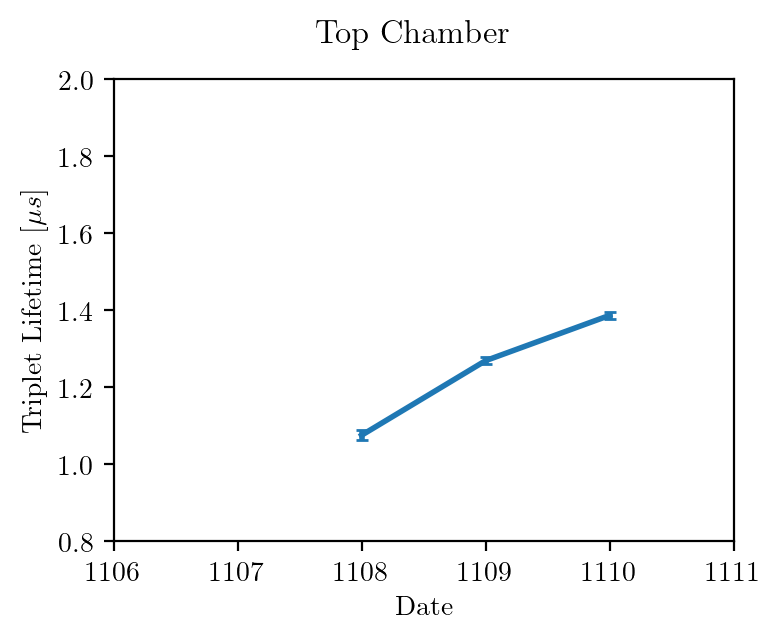

In [36]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1])
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)
plt.suptitle('Top Chamber')

## Triplet lifetime evolution (Top vs Bottom)

(0.8, 2.0)

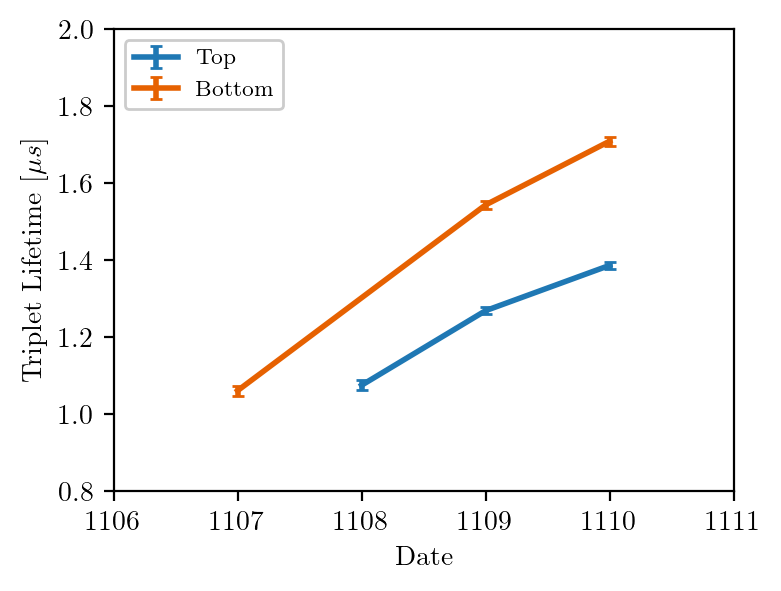

In [37]:
date_top = [1108, 1109, 1110]
tau_triplet_top = np.array(tau_triplet_top)
plt.errorbar(date_top, tau_triplet_top[:,0], yerr=tau_triplet_top[:,1], label='Top')
plt.errorbar(date_bot, tau_triplet_bot[:,0], yerr=tau_triplet_bot[:,1], label='Bottom')
plt.legend()
plt.xlim(1106, 1111)
plt.xlabel('Date')
plt.ylabel(r'Triplet Lifetime [$\mu s$]')
plt.ylim(0.8, 2.0)

# Overnight data top (1107) and bottome (1108)

In [53]:
# subdir: 0-13
dirBotON1107 = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/'
#subdir: 0-15
dirTopON1108 = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-08/2022-11-08_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_overnight/'

In [54]:
dsBotON1107 = []
dsTopON1108 = []
nsubdir = [12,16]
# gain = [[T0,T1,T2,T3],[B0,B1,B2,B3]]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]

for i,subdir in enumerate([dirBotON1107, dirTopON1108]):
    for j in range(nsubdir[i]):
        data = ds.Dataset('', pol=-1, channels=range(4), spe=gain[1-i])
        for ch in range(4):
            data.ch[ch].path = '{}{}/'.format(subdir, j)
            print(data.ch[ch].path)
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
        data.get_summed_integral_pe()
        data.get_fprompt()
        if i==0:
            dsBotON1107.append(data)
        else:
            dsTopON1108.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_overnight/0/


KeyboardInterrupt: 

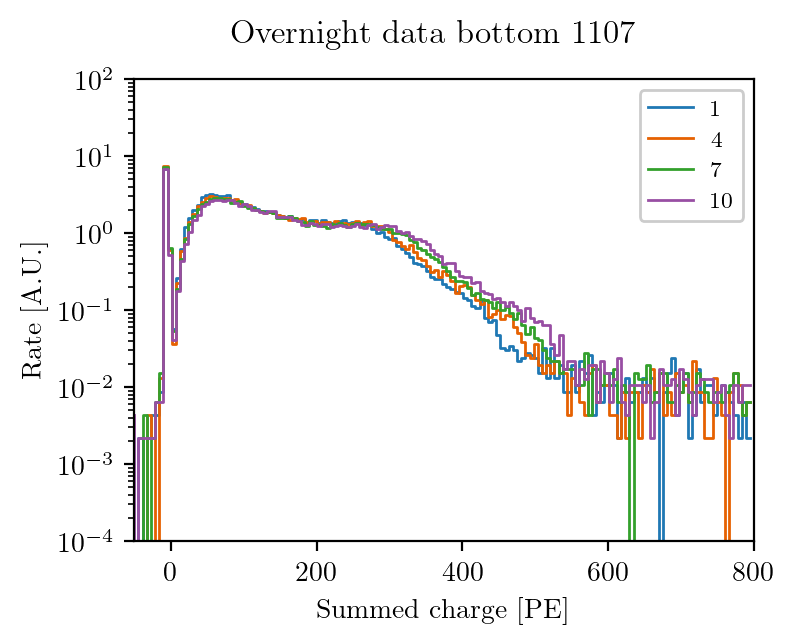

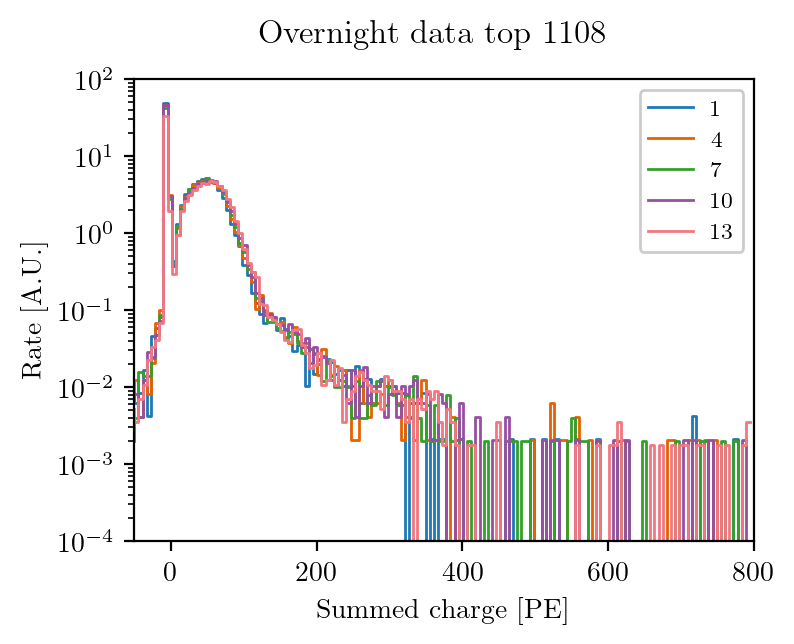

In [ ]:
xmin = -50
xmax = 800
nbins = 150
bin_width = (xmax-xmin)/nbins
titles = ['Overnight data bottom 1107', 'Overnight data top 1108']
for i in range(2):
    dsets = None
    if i==0:
        dsets = dsBotON1107
    else:
        dsets = dsTopON1108
    hist = []
    plt.figure(i)
    for j,dset in enumerate(dsets):
        h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
        # h = h/np.max(h[20:])
        h = h/dset.ch[0].cumulative_time/bin_width
        hist.append(h)
        if j%3==1:
            plt.step(hx[:-1], h, label='{}'.format(j), linewidth=1)
    # plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.xlim(xmin, xmax)
    plt.ylim(1e-4, 1e2)
    plt.xlabel('Summed charge [PE]')
    plt.ylabel('Rate [A.U.]')
    plt.suptitle(titles[i])

# High-statistics data 1109

In [3]:
dir1110_top = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/'
dir1110_bot = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_bottom_light_scintillation_coinc_111_cond_gamma_high_stat/'


In [4]:
ds1110 = [] #[top, bottom]
gain = [[526.15408, 519.05546, 507.44070, 521.98428], [518.84503, 510.84132, 504.40531, 457.59589]]
for i,dir in enumerate([dir1110_top, dir1110_bot]):
    for j in range(20):
        subdir = '{}{}/'.format(dir, j)
        print(subdir)
        data = ds.Dataset(subdir, pol=-1, channels=range(4), spe=gain[i])
        for ch in range(4):
            data.ch[ch].path = subdir
            data.ch[ch].read_data()
            data.ch[ch].baseline_subtraction()
            data.ch[ch].get_integral(prompt=0.5, long=5)
            data.ch[ch].get_avgwf(integral_range=[5*data.gain[ch], 100*data.gain[ch]])
            data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    ds1110.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/0/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/1/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/2/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/3/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/4/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coinc_111_cond_with_gamma_high_stat/5/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-10/2022-11-10_volt_65_pos_top_light_scintillation_coi

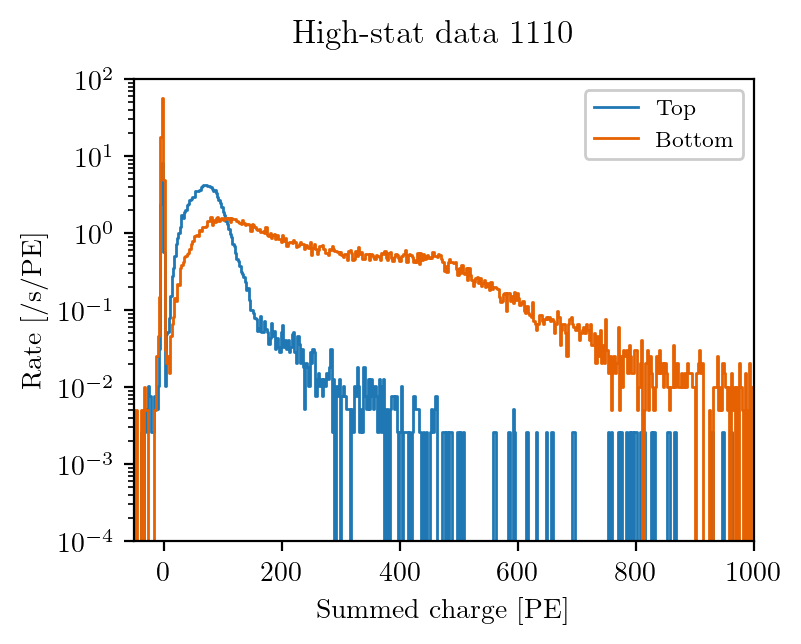

In [6]:
xmin = -50
xmax = 1000
nbins = 450
bin_width = (xmax-xmin)/nbins

plt.figure(0)
hist = []
hist_bins = []
#light yield ratio
# lyr = 5.3
# ly = [lyr, 1.0]
labels = ['Top', 'Bottom']
for i,dset in enumerate(ds1110):
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    # h = h/np.max(h[20:])
    h = h/dset.ch[0].cumulative_time/bin_width
    hist.append(h)
    hist_bins.append(hx)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-4, 1e2)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [/s/PE]')
plt.suptitle('High-stat data 1110')
plt.show()


a=0.060+/-0.002 x0=113.285+/-0.630 n=0.193+/-0.231 mu=137.932+/-4.096 sigma=4.704+/-4.643


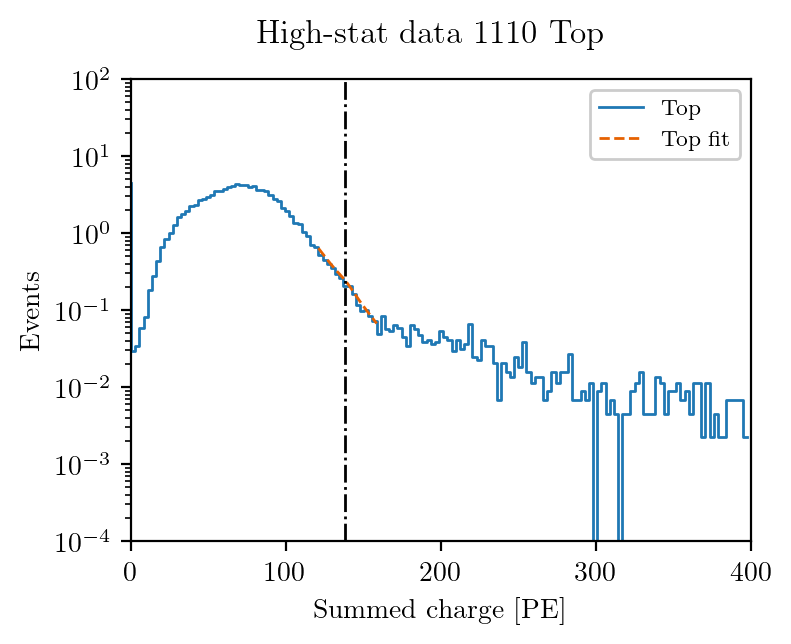

a1=-0.000+/-0.001 a2=0.010+/-0.000 x0=459.943+/-4.707 y0=0.499+/-0.019 n=0.818+/-0.366 mu=704.059+/-7.937 sigma=20.318+/-8.621


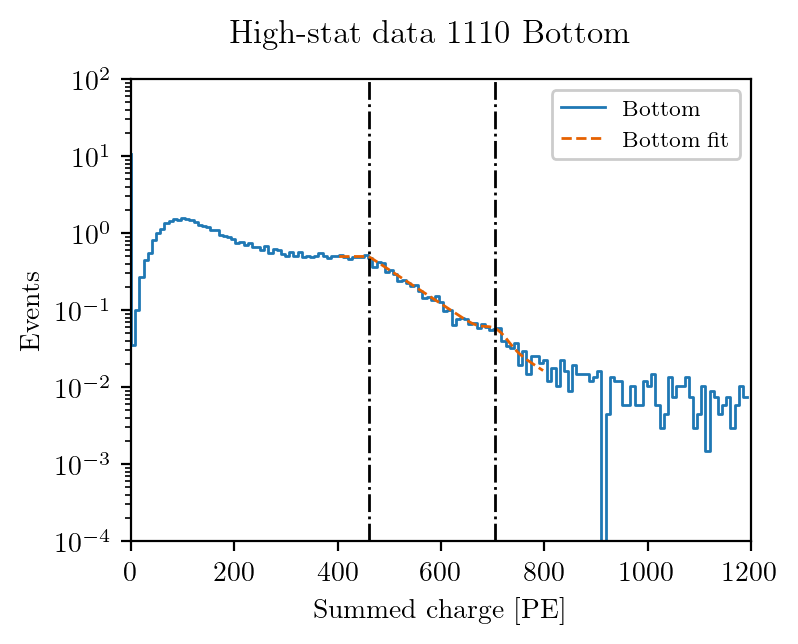

In [56]:
def fit_gamma(x, a1, a2, x0, y0, n, mu, sigma):
    a = 0
    ans = []
    for x_ in x:
        if x_<x0:
            a = a1
        else:
            a = a2
        ans.append(y0*np.exp(-a*(x_-x0)) + n/sigma/np.sqrt(np.pi*2)*np.exp(-((x_-mu)/sigma)**2/2))
    return np.array(ans)

def fit_gamma_photopeak(x, a, x0, n, mu, sigma):
    return np.exp(-a*(x-x0)) + n/sigma/np.sqrt(np.pi*2)*np.exp(-((x-mu)/sigma)**2/2)

xmin = [0, 0]
xmax = [400, 1200]
nbins = [150, 150]
init_pars = [[0.06,113,1,140,5], [0,0.01,450,2e2,1,700,20]]
fit_range_pe = [[120, 160], [400, 800]]
labels = ['Top', 'Bottom']
for i,dset in enumerate(ds1110):
    bin_width = (xmax[i]-xmin[i])/nbins[i]
    plt.figure(i)
    h,hx = np.histogram(dset.summed_integral_pe, bins=np.linspace(xmin[i],xmax[i],nbins[i]))
    h = h/dset.ch[0].cumulative_time/bin_width
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
    # Fitting
    fit_range = [int((fit_range_pe[i][0]-hx[0])/bin_width), int((fit_range_pe[i][1]-hx[0])/bin_width)]
    if i==0:
        popt, pcov = curve_fit(fit_gamma_photopeak, hx[fit_range[0]:fit_range[1]], h[fit_range[0]:fit_range[1]], p0=init_pars[i], sigma=np.sqrt(h[fit_range[0]:fit_range[1]]/dset.ch[0].cumulative_time/bin_width), maxfev=10000)
        plt.plot(hx[fit_range[0]:fit_range[1]], fit_gamma_photopeak(hx[fit_range[0]:fit_range[1]], *popt), '--', label='{} fit'.format(labels[i]), linewidth=1)
        print('a={:.3f}+/-{:.3f} x0={:.3f}+/-{:.3f} n={:.3f}+/-{:.3f} mu={:.3f}+/-{:.3f} sigma={:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0]), popt[1], np.sqrt(pcov[1,1]), popt[2], np.sqrt(pcov[2,2]), popt[3], np.sqrt(pcov[3,3]), popt[4], np.sqrt(pcov[4,4])))
        plt.plot([popt[3], popt[3]], [1e-4, 1e2], 'k-.', linewidth=1)
    else:
        popt, pcov = curve_fit(fit_gamma, hx[fit_range[0]:fit_range[1]], h[fit_range[0]:fit_range[1]], p0=init_pars[i], sigma=np.sqrt(h[fit_range[0]:fit_range[1]]/dset.ch[0].cumulative_time/bin_width), maxfev=10000)
        plt.plot(hx[fit_range[0]:fit_range[1]], fit_gamma(hx[fit_range[0]:fit_range[1]], *popt), '--', label='{} fit'.format(labels[1]), linewidth=1)
        print('a1={:.3f}+/-{:.3f} a2={:.3f}+/-{:.3f} x0={:.3f}+/-{:.3f} y0={:.3f}+/-{:.3f} n={:.3f}+/-{:.3f} mu={:.3f}+/-{:.3f} sigma={:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0]), popt[1], np.sqrt(pcov[1,1]), popt[2], np.sqrt(pcov[2,2]), popt[3], np.sqrt(pcov[3,3]), popt[4], np.sqrt(pcov[4,4]), popt[5], np.sqrt(pcov[5,5]), popt[6], np.sqrt(pcov[6,6])))
        plt.plot([popt[2], popt[2]], [1e-4, 1e2], 'k-.', linewidth=1)
        plt.plot([popt[5], popt[5]], [1e-4, 1e2], 'k-.', linewidth=1)
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.xlim(xmin[i], xmax[i])
    plt.ylim(1e-4, 1e2)
    plt.xlabel('Summed charge [PE]')
    plt.ylabel('Events')
    plt.suptitle('High-stat data 1110 {}'.format(labels[i]))
    plt.show()


In [44]:
selected_wfid = ds1109[0].get_waveforms_id(count=10, integral_range=(-5,0))
selected_wf = []
for ch in range(4):
    print(ds1109[0].ch[ch].trigger_position*ds1109[0].ch[0].sample_step)
    selected_wf.append(ds1109[0].ch[ch].get_waveforms(event_id=selected_wfid))

NameError: name 'ds1109' is not defined

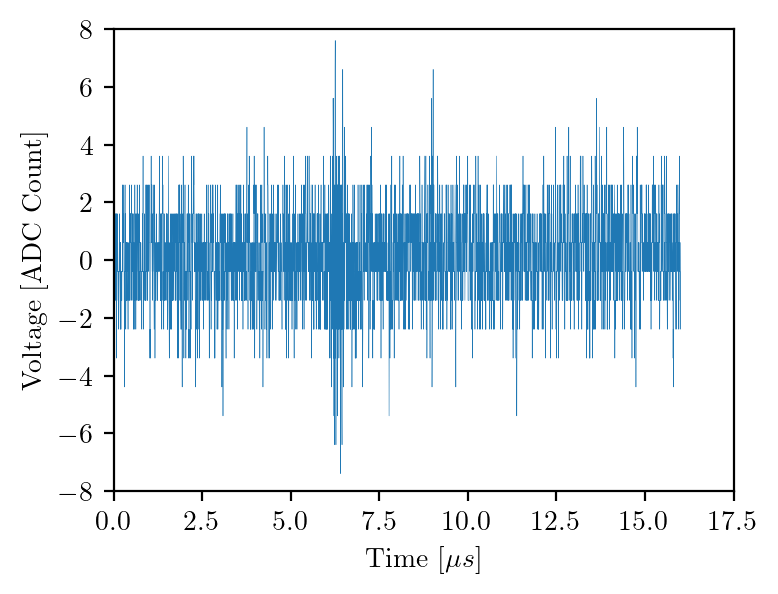

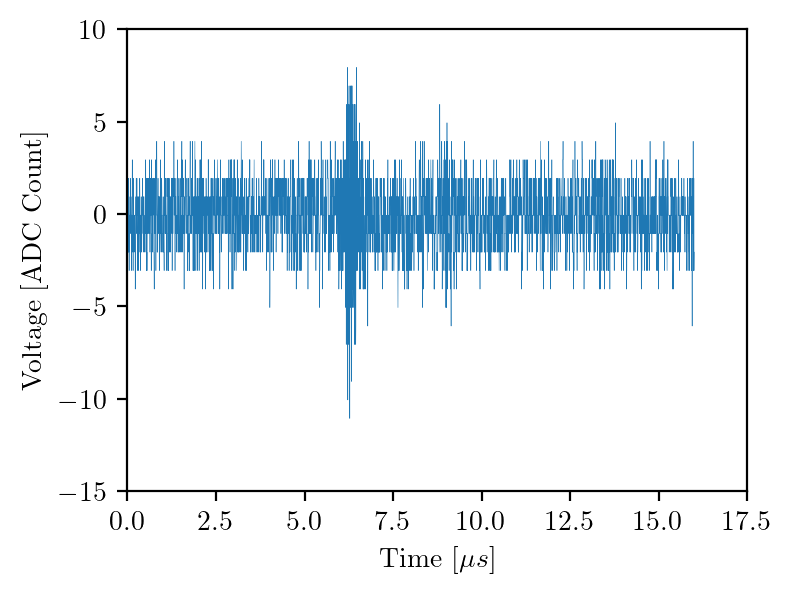

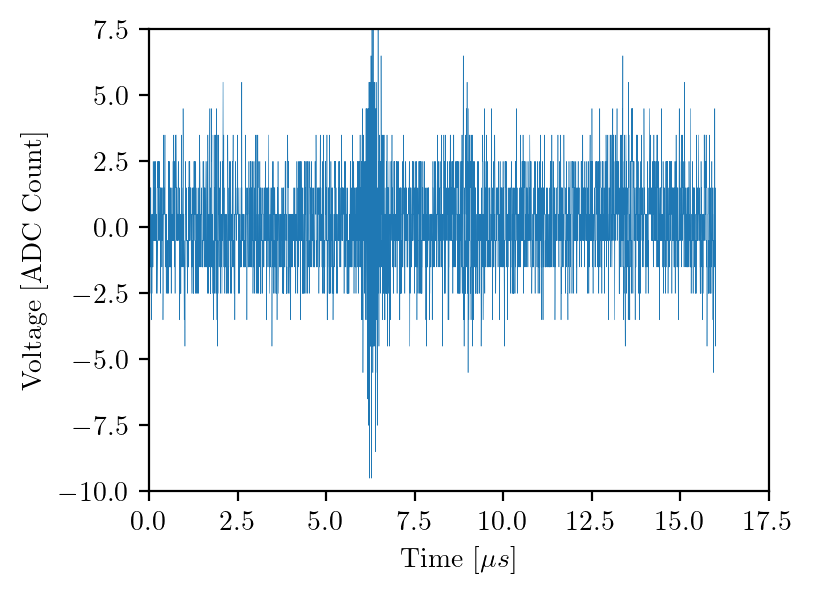

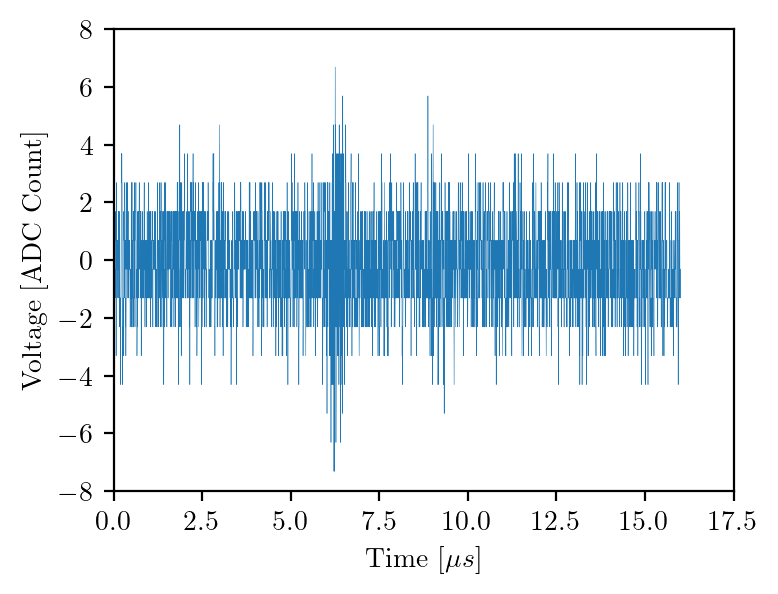

: 

In [ ]:
tmin = 0
tmax = 16.0
tmin_sample = int(tmin/ds1109[0].ch[0].sample_step)
tmax_sample = int(tmax/ds1109[0].ch[0].sample_step)
for ch in range(4):
    plt.figure(ch)
    for iwf in range(1):
        plt.plot(ds1109[0].ch[ch].time[tmin_sample:tmax_sample], selected_wf[ch][iwf][tmin_sample:tmax_sample], linewidth=0.2)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [ADC Count]')